# Text preprocessing and exploratory data analysis

In this notebook I will perform some analysis on the part of the WMT'14 dataset that I am going to use for my translation system in order to gain some intuition about how to preprocess it. I will then write the code to preprocess the data and save them to file.

## The dataset

Here I will introduce the dataset, experiment with it, tokenize it, preprocess it and save it to a new set of files. I will also write a few helper functions.

In [1]:
import codecs
import numpy as np

lang_t = 'en'
lang_s = 'fr'
prep_path = "/DATA/"

f1_fr = codecs.open("DATA/en-fr_paropt/dev.tok.fr", encoding='utf-8')
f2_fr = codecs.open("DATA/en-fr_paropt/train.fr", encoding='utf-8')
#test_fr = codecs.open("DATA/en-fr_paropt/test.fr", encoding='utf-8')
source = eval("f1_"+lang_s).read()+"\n"+eval("f2_"+lang_s).read()


f1_en = codecs.open("DATA/en-fr_paropt/dev.tok.en", encoding='utf-8')
f2_en = codecs.open("DATA/en-fr_paropt/train.en", encoding='utf-8')
#test_en = codecs.open("DATA/en-fr_paropt/test.en", encoding='utf-8')
target = eval("f1_"+lang_t).read()+"\n"+eval("f2_"+lang_t).read()


#i = source.index(u'pr\xe9sident m. rohan')
#print i, source[i:i+60]
char_length_s = len(source)
char_length_t = float(len(target))
s_length = len(source.split('\n'))
t_length = len(target.split('\n'))
print "FRENCH: \n", source[99:320], "\n***************\nENGLISH: \n", target[100:300]
print "\nCharacter length of both corpora: {}, {}. French is {:0.2f}% 'bulkier' than English.".format(
                                char_length_s, char_length_t, 100*((char_length_s/char_length_t)-1))
print "Phrase length of both corpora: {}, {}".format(s_length, t_length)

FRENCH: 
, son épouse enseignante de jardin d&apos; enfants , Roseanna , et Geneviève se préparaient à partir en voyage en famille .
Ce changement d&apos; époque est en même temps le problème de toute la démocratie chrétienne , et 
***************
ENGLISH: 
and Genevieve were getting ready to go on a family trip .
The beginning of a new era means a problem for all Christian democracy , including Angela Merkel as well .
Obama ? The first anti-American Pre

Character length of both corpora: 155125826, 128673246.0. French is 20.56% 'bulkier' than English.
Phrase length of both corpora: 1013625, 1013625


A few observations so far: 
- French takes 20% more characters to convey similar information. We haven't looked at tokens/words yet but I predict the French corpus will have more words than the English, rather than having a higher average number of characters per word.
- The data is in unicode `utf-8` format, so we need to be careful with string manipulations and encoders/decoders.
- There are plenty of commas, full stops (periods) and other bits of punctuation, which may affect the understanding of a sentence to a native speaker, as made famous in [Eats, Shoots & Leaves](https://en.wikipedia.org/wiki/Eats,_Shoots_%26_Leaves), however for our intents and purposes all punctuation apart from apostrophes will be removed from the texts. This is because these tokens will occur very often in the text and so the machine learning algorithms will weight their importance far higher than it actually is in conveying meaning. Some exceptions will be full stops indicating abbreviations, for example in F.B.I.




In [2]:
def remove_punc(text):
    # Needs to keep stops like L.A.P.D.
    # almost all other punctuation needs to be carefully removed
    text = unicode.strip(text)
    text = unicode.replace(text, " .", u"")
    text = unicode.replace(text,",", u"")
    text = unicode.replace(text,u" .", u"")
    text = unicode.replace(text,u" ,", u"")
    text = unicode.strip(text, ",:)(][}{!")
    text = unicode.strip(text, u",:)(][}{;!")
    text = unicode.replace(text,u':', u'')
    text = text.replace(u';', u'')
    text = text.replace(')', u'')
    text = text.replace("(", u'')
    text = text.replace("!", u':')
    #text = text.replace(u"     ", " ")
    text = text.replace(u"    ", " ")
    text = text.replace(u"   ", " ")
    text = text.replace(u"  ", " ")
    return text

source = remove_punc(source)
target = remove_punc(target)
print "Source text is now {} less bulky than before stripping punctuation.".format(
                                        100*((float(char_length_s)-len(source))/float(char_length_s)))
print "Target text is now {} less bulky than before stripping punctuation..".format(
                                        100*((float(char_length_t)-len(target))/float(char_length_t)))
source = source.split("\n") # split text up by lines
target = target.split("\n")

Source text is now 3.99968474624 less bulky than before stripping punctuation.
Target text is now 3.78273662265 less bulky than before stripping punctuation..


Stripping punctuation decreases the corpora length by around 4%, this is certainly non-negligible and will help a lot.

# Tokenising the data

Thankfully, the dataset I have used is already split up by whitespace into appropriate tokens. For example in French "j'" and "ai" are treated as separate tokens which make up "j'ai" to mean "I have" in English. Similarly, "didn" and "'t" are separated by whitespace. This makes tokenising the data as trivial as calling the `split()` method on each sequence string. 

In [3]:
import nltk
def tokenize_sentences(text_source, text_target):
    new_text_s = []
    new_text_t = []
    for sent_s, sent_t in zip(text_source, text_target):
        # This splits up tokens within a sentence and removes whitespace from the ends
        tok_s = (unicode.strip(sent_s.lower())).split(' ')
        tok_t = (unicode.strip(sent_t.lower())).split(' ')
        
        
        # I'm keeping the final punctuation and appending the
        # <EOS> tag after it
        new_text_s.append(tok_s)
        new_text_t.append(tok_t)
    #print "There are now {} sequence pairs remaining.".format(len(new_text_t))
    print "Corpora still same length: {}".format(len(new_text_t)==len(new_text_s))
    return new_text_s, new_text_t

source_long, target_long = tokenize_sentences(source, target)
del source, target
print source_long[10], "\n", target_long[10]

Corpora still same length: True


# Sequence length

Now I will look at a few statistics in order to find a reasonable sequence length limit and a justification for doing so. I found that reducing the range of sequence lengths makes the algorithm orders of magnitude faster to train.

In [4]:
from scipy.stats import mode

def sequence_stats(text):
    lengths = sorted([len(seq) for seq in text])
    l_min = np.min(lengths)
    l_max = np.max(lengths)
    l_mean = np.mean(lengths)
    l_median = np.median(lengths)
    l_mode = mode(lengths)[0][0]
    percentile_25 = np.percentile(lengths, 25)
    percentile_75 = np.percentile(lengths, 75)
    print "Min: {}  Max: {}  Mean: {:0.2f}   Median: {}   Mode: {}   1st Quart.: {}   IQR: {}   3rd Quart.: {}".format(
                                            l_min,l_max,l_mean, l_median, l_mode, percentile_25, percentile_75-percentile_25,percentile_75)
    return
print "Language:", lang_s
sequence_stats(source_long)
print "Language:", lang_t
sequence_stats(target_long)

fr
Min: 1  Max: 124  Mean: 24.00   Median: 21.0   Mode: 14   1st Quart.: 13.0   IQR: 18.0   3rd Quart.: 31.0
en
Min: 1  Max: 125  Mean: 20.17   Median: 18.0   Mode: 12   1st Quart.: 11.0   IQR: 15.0   3rd Quart.: 26.0


In [49]:
print 31+1.5*18
print 26+1.5*15

58.0
48.5


Although the maximum sequence lengths are very high in both the French and English corpora (124 and 125 words respectively), the mean and median are far lower, with a mean larger than median inidicating that the sequence length distribution is skewed. In fact, 25% of the Fr and En data is made up of sequences smaller than 13 and 11 tokens long, respectively and 50% by the medians 21 and 18. Due to the skewedness of the data, the interquartile range overlaps with zero in each case so there is no obvious lower bound to define outliers by using $Median-1.5IQR$. An upper bound of $Median+1.5IQR$ would mean that any sequences longer than 58 and 49 could be deemed outliers, using the standard approach. However, these sequences are still very long, considering that most of the data is a third of the length of this upper bound. Processing these sequences will be very challenging as their presence will cause batches to be padded with a large number of `<PAD>` tokens. The single layered LSTM encoder/decoder will also find it very difficult to compress/extract all of the information in the very long sequences.

In order to make the model easier to train I will only consider sequences up to the median length. This means that French (English) sequences longer than 21 (18) tokens long are discarded while maintaining half of the overall dataset. Although this is a harsh approximation, I think it is justified since the aim of this experiment is to learn how to implement sequence-to-sequence modelling and not to create a cutting edge solution, so the decrease in rigour is worth the increase in trainability. Going from around 1,000,000 training examples to 500,000 should still be sufficient to train a toy model on.

## Removing long seqences

Here I implement the discussion above and generate some word frequency statistics along the way.

In [10]:
def shorten_data(source_, target_):
    flat_s = []
    flat_t = []
    source = []
    target = []
    for seq_s, seq_t in zip(source_, target_):
        bool_short_s = (len(seq_s)<=21)
        bool_short_t = (len(seq_t)<=19)
        bool_asymm = (abs(len(seq_t)-len(seq_s))<10)
        if bool_short_s and bool_short_t:
            flat_s += seq_s
            flat_t += seq_t
            source.append(seq_s)
            target.append(seq_t)
    print "There are now {} sequence pairs remaining.".format(len(source))
    return source, nltk.FreqDist(flat_s), target, nltk.FreqDist(flat_t)


source, freq_s, target, freq_t = shorten_data(source_long, target_long)
print "Language:", lang_s
sequence_stats(source)
print "Language:", lang_t
sequence_stats(target)

There are now 469624 sequence pairs remaining.
Language: fr
Min: 1  Max: 21  Mean: 12.82   Median: 13.0   Mode: 14   1st Quart.: 9.0   IQR: 8.0   3rd Quart.: 17.0
Language: en
Min: 1  Max: 19  Mean: 10.97   Median: 11.0   Mode: 12   1st Quart.: 8.0   IQR: 6.0   3rd Quart.: 14.0


# Limiting the vocabulary

Here I'll check that the word statistics of the dataset are what I expect and then use some of the insights to find an appropriate upper bound on the number of vocabulary words I use.


[(u'the', 269274), (u'and', 132831), (u'of', 131523), (u'to', 111982)]
[(u'de', 288132), (u'la', 153223), (u'les', 133904), (u'et', 124541)]
English Vocabulary size: 140873
Total proportion are hapaxes: 54.1310258176
French Vocabulary size: 184012
Total proportion are hapaxes: 52.6259157011


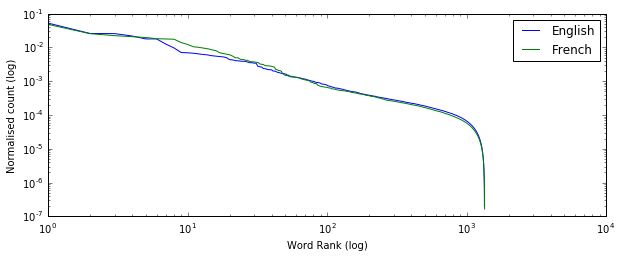

In [24]:
print freq_t.most_common(4)
print freq_s.most_common(4)
import matplotlib.pyplot as plt
import string

def plot_pareto(freq, ax, l):
    counts_list = sorted(set(freq.values()))
    total_counts = float(sum(freq.values()))
    vocab_total= len(freq.keys())
    print "{} Vocabulary size: {}".format(l, vocab_total)
    print "Total proportion are hapaxes: {}".format((len(freq.hapaxes())/float(vocab_total))*100)
    d = dict()
    for word, count in freq.items():
        if word not in string.punctuation.encode('utf-8'):
            if count in d.keys():
                pass
            else:
                d[count] = word
    y, words = tuple(zip(*d.items()))
    x, y = zip(*[(n, count/total_counts) for n,count in enumerate(sorted(y,reverse=True),1)])
    ax.loglog(x,y,label=l)
    ax.set_ylabel("Normalised count (log)")
    ax.set_xlabel("Word Rank (log)")
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
plot_pareto(freq_t, ax1, 'English')
#ax1.set_title("English")
#plt.legend()
#plt.savefig("English-pareto.pdf")
#fig = plt.figure()

#ax2 = fig.add_subplot(221)
plot_pareto(freq_s, ax1, 'French')
#ax2.set_title("French")
plt.legend()
#plt.savefig("French-pareto.pdf")
plt.show()
#freqs = freq_t_d.values()
#h, bins_edges = np.histogram(freqs, bins=vocab_size)
#plt.hist(h, bins=bins_edges)


In the above plot, we see normalised word frequency for words of each rank, that is the score that would be assigned to a word given the number of times it occurs in the text. For example, the word "the" occurs the most number of times in the English dataset and so is given rank of 1, etc. We see the famous Pareto distribution of words, the straight line indicating that there is a particular power law scaling. In this case the power law states that the rank 1 word is twice as common as the rank 2 word, the rank 2 word is three times as common as the rank 3 word and so on, which is shown nicely in the printed statistics above. The trailing off for uncommon words (large word rank) is due to the finite size of the dataset.

We can also see that the total vocabulary used for English and French are 140873 and 184012, with over half of the vocabulary words only occurring once in the entire corpus (known hapax legomenon). These are fairly useless, as there are not enough different contexts of a word for the algorithm to learn it's meaning, particularly as they are likely to be obscure words/jargon anyway. This means that straight away, 75-95,000 words can be removed, which is a good start, but probably not enough.

In [48]:
def covered_with_vocab(freq_dist, vocab_size, lang):
    total_words = len(freq_dist.keys())
    total_length = sum(freq_dist.values())
    print "{} vocab size of {} restricts to {:0.2f} percent of total vocab.".format(lang, vocab_size, 100*(float(vocab_size)/total_words))
    vocab = dict(freq_dist.most_common(vocab_size))
    #print "vocab size= ",len(vocab.keys())
    covered_with_vocab = sum(vocab.values()) # Total of frequencies
    print "\tPercentage of whole {} corpus covered by vocab: {:0.2f}".format(lang,
                                            100*(covered_with_vocab/float(total_length)))
    return
vs_s1 = 25000
vs_s2 = 12500
vs_t1 = 20000
vs_t2 = 10000
covered_with_vocab(freq_s, vs_s1, lang_s)
covered_with_vocab(freq_s, vs_s2, lang_s)
covered_with_vocab(freq_s, 207, lang_s)
print
covered_with_vocab(freq_t, 350, lang_t)
covered_with_vocab(freq_t, vs_t1, lang_t)
covered_with_vocab(freq_t, vs_t2, lang_t)

fr vocab size of 25000 restricts to 13.59 percent of total vocab.
	Percentage of whole fr corpus covered by vocab: 93.99
fr vocab size of 12500 restricts to 6.79 percent of total vocab.
	Percentage of whole fr corpus covered by vocab: 89.30
fr vocab size of 207 restricts to 0.11 percent of total vocab.
	Percentage of whole fr corpus covered by vocab: 50.01

en vocab size of 350 restricts to 0.25 percent of total vocab.
	Percentage of whole en corpus covered by vocab: 50.01
en vocab size of 20000 restricts to 14.20 percent of total vocab.
	Percentage of whole en corpus covered by vocab: 94.92
en vocab size of 10000 restricts to 7.10 percent of total vocab.
	Percentage of whole en corpus covered by vocab: 89.27


In [55]:
print "vocab difference =", ((184012-140873.)/140873)*100
print "core usage difference =",((350-207)/350.)*100

vocab difference = 30.6226175349
core usage difference = 40.8571428571


As we can see, it takes only around 14% of the vocabulary to cover 94-95% of the entire corpora and 7% of the vocabulary to cover 89%. In fact, with just 207 and 350 words you can cover 50% of the French and English corpora, respectively - this is the remarkable scaling properties of word frequency in action. This also shows an interesting insight, although French has 31% more words in its vocabulary, far fewer words (41% fewer!) make up its _core_ than English.

94-95% of the corpus being covered by the vocabulary means that around 5 or 6 words in 100 will be replaced by an `<UNK>` token, this is likely to be sufficient to maintain enough information in source and target phrases for the model to learn from, while reducing the number of parameters in the model substantially. Given this, the vocabulary sizes for French and English will be 25,000 and 20,000, respectively.

# Replacing word tokens with IDs

Now I will create dictionaries mapping from word tokens to their respective ID and vice versa. This will make it easy to define a sparse vector representation for each word as well as making it possible to index embedding arrays (dense representations) efficiently. We must remember to reserve IDs 0, 1 and 2 for `<PAD>`, `<EOS>` and `<UNK>`.

In [61]:
vocab_size_s = 25000
vocab_size_t = 20000
def word_to_ids(freq_dist, vocab_size, lang):
    vocab = dict(freq_dist.most_common(vocab_size))
    # IDs begin at 3 because <EOS>=1 and <UNK>=2
    word_to_ids = dict([(word, i+3) for i, word in enumerate(vocab.keys())])
    word_to_ids[u'<UNK>'] = 2
    word_to_ids[u'<EOS>'] = 1
    word_to_ids[u'<PAD>'] = 0
    id_to_words = dict((idx, word) for word, idx in word_to_ids.items())
    return word_to_ids, id_to_words


word2id_s, id2word_s = word_to_ids(freq_s, vocab_size_s, lang_s)
word2id_t, id2word_t = word_to_ids(freq_t, vocab_size_t, lang_t)
print word2id_t['hello'], id2word_t[2345]

3745 meteorological


Then we can use the `word2id` dictionaries to swap out the various words for their IDs. 

In [65]:
from multiprocessing import Pool

def replace_id_func(sequence, **kwargs):
    # Parallelisable version of word to ID replacer
    word2id=kwargs['wtid']
    ids_sent = [] # sentence with words replaced by ids
    sequence+=[u'<EOS>']
    for token in sequence:
        if token not in word2id.keys():
            if token == u'<EOS>':
                ids_sent.append(1)
            else:
                ids_sent.append(2)
        else:
            ids_sent.append(word2id[token])
    return ids_sent

def replace_with_word_id(text, wtid, lang):
    '''
    take the list of lists, find FreqDist, replace any
    out of vocabulary words with <UNK> whilst giving each
    token a numerical ID, return new list of lists'''
    ti = time.time()
    prep_text = []
    pool = Pool(processes = 3)
    kwargs = {'wtid': wtid}
    # Parallelise process, set buffer size to restrict memory usage
    id_text = [i for i in pool.imap(partial(replace_id_func, **kwargs), text, chunksize=20000)]
    print "Replacing {} words with IDs took {} seconds.".format(lang, time.time()-ti)
    return id_text

source_ids = replace_with_word_id(source, word2id_s, lang_s)
target_ids = replace_with_word_id(target, word2id_t, lang_t)


'\nsource_ids = replace_with_word_id(source, word2id_s, lang_s)\ntarget_ids = replace_with_word_id(target, word2id_t, lang_t)\n'

In [64]:
from utils import load_obj, save_obj
from sklearn.cross_validation import train_test_split
"""
source_train, source_test, target_train, target_test = train_test_split(
                            source_ids.split('\n'), target_ids.split('\n'),
                            test_size=test_fraction, random_state=42)

data_dic = {"s_train": source_train, "t_train": target_train,
                "s_test": source_test, "t_test": target_test,
                "word2id_s": word2id_s, "word2id_t": word2id_t,
                "id2word_s": id2word_s, "id2word_t": id2word_t}
save_obj(data_dic, "DATA/data_dic")
print "DATA saved"
"""

data_dic = load_obj("DATA/data_dic")
print "DATA loaded"

DATA saved


All done!